  Development Name   Borough  Account Name                   Location  \
0     BAISLEY PARK    QUEENS  BAISLEY PARK                     BLD 09   
1     BAISLEY PARK    QUEENS  BAISLEY PARK                     BLD 09   
2     BAISLEY PARK    QUEENS  BAISLEY PARK                     BLD 09   
3     BAISLEY PARK    QUEENS  BAISLEY PARK                     BLD 09   
4         BAY VIEW  BROOKLYN      BAY VIEW  BLD 25 - Community Center   

  Meter AMR       Meter Scope  TDS #  EDP  RC Code      Funding Source  ...  \
0       AMR            BLD 09   91.0  240  Q009100             FEDERAL  ...   
1       AMR            BLD 09   91.0  240  Q009100             FEDERAL  ...   
2       AMR            BLD 09   91.0  240  Q009100             FEDERAL  ...   
3       AMR            BLD 09   91.0  240  Q009100             FEDERAL  ...   
4      NONE  Community Center   92.0  670  K209200  MIXED FINANCE/LLC1  ...   

  Service End Date # days  Meter Number Estimated Current Charges  \
0       01/26/202

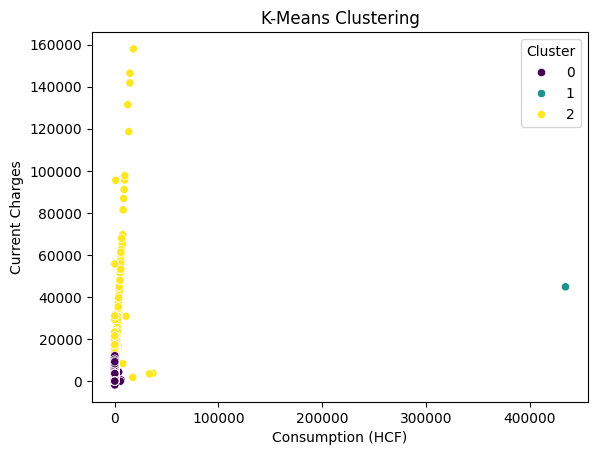

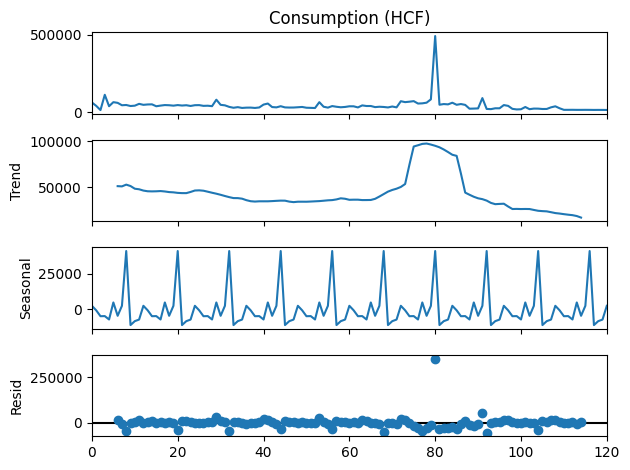

                               SARIMAX Results                                
Dep. Variable:      Consumption (HCF)   No. Observations:                  121
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1454.425
Date:                Fri, 13 Dec 2024   AIC                           2914.851
Time:                        18:54:41   BIC                           2923.213
Sample:                             0   HQIC                          2918.247
                                - 121                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0278      0.096      0.288      0.773      -0.161       0.217
ma.L1         -0.8734      0.055    -15.938      0.000      -0.981      -0.766
sigma2      2.184e+09   7.58e-11   2.88e+19      0.0

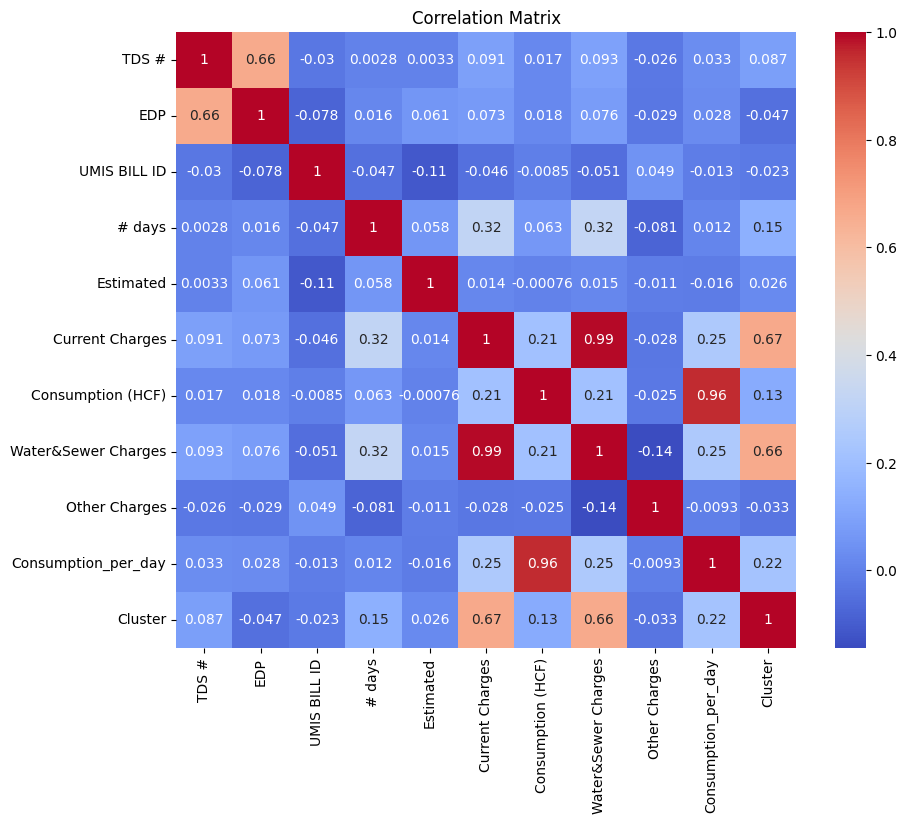

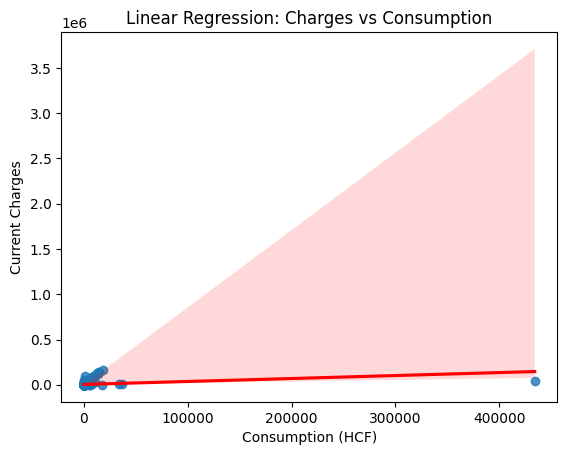

Linear Regression - MAE: 3217.0207428389813, MSE: 37815205.2192381, RMSE: 6149.40689979433
Decision Tree - Accuracy: 0.9077708006279435, Precision: 0.6188811188811189, AUC: 0.7678030386557587
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      2245
           1       0.62      0.58      0.60       303

    accuracy                           0.91      2548
   macro avg       0.78      0.77      0.77      2548
weighted avg       0.91      0.91      0.91      2548



In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (
    roc_auc_score, precision_score, accuracy_score,
    mean_absolute_error, mean_squared_error, classification_report
)
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset
file_path = r"C:\Users\billj\Downloads\smart-city-water-metering-and-governance\Dataset\Water_Consumption_And_Cost__2013_-_Feb_2023_.csv"
data = pd.read_csv(file_path)

# Data Overview
print(data.head())
print(data.info())

# Handle Missing Values
data = data.dropna()

# Convert Dates to Datetime
data['Service Start Date'] = pd.to_datetime(data['Service Start Date'])
data['Service End Date'] = pd.to_datetime(data['Service End Date'])

# Feature Engineering: Consumption per Day
data['Consumption_per_day'] = data['Consumption (HCF)'] / data['# days']

# Remove Infinite and Large Values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()  # Drop rows with infinite or NaN values

# Select Relevant Columns
features = ['Consumption (HCF)', 'Consumption_per_day', 'Current Charges']
target = 'Estimated'  # Classification Target (Y/N)

# Encode Target Variable
data['Estimated'] = data['Estimated'].apply(lambda x: 1 if x == 'Y' else 0)

# Split Dataset into Features and Target
X = data[features]
y = data[target]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Linear Regression
regressor = LinearRegression()
regressor.fit(X_train[['Consumption (HCF)']], X_train['Current Charges'])

# Predictions and Evaluation
y_pred_lr = regressor.predict(X_test[['Consumption (HCF)']])
mae = mean_absolute_error(X_test['Current Charges'], y_pred_lr)
mse = mean_squared_error(X_test['Current Charges'], y_pred_lr)
rmse = np.sqrt(mse)

print(f"Linear Regression - MAE: {mae}, MSE: {mse}, RMSE: {rmse}")

# 2. Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_tree = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_tree)
precision = precision_score(y_test, y_pred_tree)
roc_auc = roc_auc_score(y_test, y_pred_tree)

print(f"Decision Tree - Accuracy: {accuracy}, Precision: {precision}, AUC: {roc_auc}")

# 3. K-Means Clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add Cluster Labels to Data
data['Cluster'] = clusters

# Visualize Clusters
sns.scatterplot(data=data, x='Consumption (HCF)', y='Current Charges', hue='Cluster', palette='viridis')
plt.title("K-Means Clustering")
plt.show()

# 4. Time Series Analysis
data['Revenue Month'] = pd.to_datetime(data['Revenue Month'])
monthly_data = data.groupby('Revenue Month')['Consumption (HCF)'].sum().reset_index()

# Time Series Decomposition
decomposition = sm.tsa.seasonal_decompose(monthly_data['Consumption (HCF)'], period=12)
decomposition.plot()
plt.show()

# ARIMA Model
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(monthly_data['Consumption (HCF)'], order=(1, 1, 1))
results = model.fit()

print(results.summary())

# Correlation Heatmap (Only Numeric Columns)
numeric_data = data.select_dtypes(include=[np.number])

# Plot Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


# Regression Plot
sns.regplot(x='Consumption (HCF)', y='Current Charges', data=data, line_kws={"color": "red"})
plt.title("Linear Regression: Charges vs Consumption")
plt.show()

# Evaluation Summary
print(f"Linear Regression - MAE: {mae}, MSE: {mse}, RMSE: {rmse}")
print(f"Decision Tree - Accuracy: {accuracy}, Precision: {precision}, AUC: {roc_auc}")
print(classification_report(y_test, y_pred_tree))
